### Measuring correlations between trip flows X education points of interest of Boston metro area
##### This notebook compares number of trips per grid cell and education points of interest. For this analysis, we used the number of enrolled students in universities, high schools, colleges, and elementary and middle schools.
##### We use Pearson's correlation coefficient and predictive power score in this comparison. 
##### Questions:
* How is the correlation between a POI and the number of bike trips that start or end in the grid cells?
* How is the impact of independent variables on the correlation? The evaluated variables are: cell as origin or destination of the trips, grid size, day period, year period

In [1]:
import pandas as pd
import shapely.wkt as sw
import geopandas as gpd
import folium
import gc
import matplotlib.pyplot as plt

import bikescience.load_trips as tr
import bikescience.stations as st
from bikescience import grid_placements as pl
import bikescience.flow as flow
import bikescience.grid as gr
import pandas as pd
import seaborn as sns
import ppscore as pps
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

base_folder = '../data/boston/training-sets/poi/'
cell_id = ['i', 'j', 'placement_id']

/home/higor/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Changing grid limits to include an uncovered area

In [ ]:
gr.default_north_limit = gr.default_north_limit - 0.005
gr.default_south_limit = gr.default_south_limit - 0.030
gr.default_east_limit = gr.default_east_limit + 0.012
gr.default_west_limit = gr.default_west_limit - 0.012

#### Defining grid size

In [2]:
grid = gr.Grid(n=10)

#### Auxiliary functions

In [3]:
def heatmap_corr(df):
    f, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(df, vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True)
    ax.set_title('Correlation matrix')
    return ax

def heatmap_pps(df):
    f, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
    ax.set_title('PPS matrix')
    ax.set_xlabel('feature')
    ax.set_ylabel('target')
    return ax

#### Loading trips

In [5]:
trips = tr.load_all_trips('../data/boston/bike-trips')
print(len(trips), 'trips')
stations = st.load('../data/boston/bike-stations/stations.geojson')
print(len(stations), 'stations')

In [65]:
filtered_trips = trips

#only working days
filtered_trips = tr.working_days(filtered_trips)

#different day periods
#filtered = tr.morning(filtered)
#filtered = filtered[(filtered['hour'] >= 6) & (filtered['hour'] < 9)]
#filtered = filtered[(filtered['hour'] >= 11) & (filtered['hour'] < 14)]
#filtered = filtered[(filtered['hour'] >= 17) & (filtered['hour'] < 20)]

# after a date
#filtered_trips = trips[trips.starttime >= pd.Timestamp('2018-01-01 00:00:0000')]

# between April and November of all years
'''
filtered = trips[((trips.starttime >= pd.Timestamp('2019-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2019-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2019-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2019-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2018-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2018-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2018-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2018-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2017-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2017-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2017-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2017-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2016-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2016-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2016-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2016-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2015-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2015-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2015-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2015-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2014-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2014-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2014-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2014-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2013-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2013-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2013-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2013-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2012-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2012-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2012-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2012-12-01 00:00:0000')))]
'''

print(len(filtered_trips), 'trips')

1914002 trips


#### Creating the OD matrix

In [66]:
od = flow.od_countings(filtered, grid, stations)
od.drop(columns=['origin','destination'],inplace=True)
od.head()

/home/higor/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:4326 +type=crs != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


i_start  j_start  i_end  j_end  trip counts
0        0        3      0      3            8
1        0        3      0      5            2
2        0        3      1      3           68
3        0        3      1      4            2
4        0        3      1      6            1

#### Education data

In [8]:
boston_universities = gpd.read_file(base_folder+'us-universities-boston.geojson')
boston_universities = boston_universities[['ipedsid','name','tot_enroll','geometry']]
boston_universities.columns = ['id','name','total_students','geometry']
boston_public_schools_all = gpd.read_file(base_folder+'us-public-schools-boston.geojson')
boston_public_schools_all = boston_public_schools_all[['school_id','school_name','total_students','geometry']]
boston_public_schools_all.columns = ['id','name','total_students','geometry']
boston_public_high_schools = gpd.read_file(base_folder+'us-public-high-schools-boston.geojson')
boston_public_high_schools = boston_public_high_schools[['school_id','school_name','total_students','geometry']]
boston_public_high_schools.columns = ['id','name','total_students','geometry']
boston_private_schools_all = gpd.read_file(base_folder+'us-private-schools-boston.geojson')
boston_private_schools_all = boston_private_schools_all[['school_id','school_name','total_students','geometry']]
boston_private_schools_all.columns = ['id','name','total_students','geometry']
boston_private_high_schools = gpd.read_file(base_folder+'us-private-high-schools-boston.geojson')
boston_private_high_schools = boston_private_high_schools[['school_id','school_name','total_students','geometry']]
boston_private_high_schools.columns = ['id','name','total_students','geometry']
# joining public and private schools
boston_schools_all = boston_public_schools_all
boston_schools_all = boston_schools_all.append(boston_private_schools_all)
boston_high_schools = boston_public_high_schools
boston_high_schools = boston_high_schools.append(boston_private_high_schools)
#joining universities and schools
boston_education = boston_universities
boston_education_all = boston_education.append(boston_schools_all)
boston_high_education = boston_education.append(boston_high_schools)
print('universities: '+str(len(boston_universities)))
print('all public schools: '+str(len(boston_public_schools_all)))
print('all private schools: '+str(len(boston_private_schools_all)))
print('all schools: '+str(len(boston_schools_all)))
print('public high schools: '+str(len(boston_public_high_schools)))
print('private high schools: '+str(len(boston_private_high_schools)))
print('high schools: '+str(len(boston_high_schools)))
print('all education: '+str(len(boston_education_all)))
print('high education: '+str(len(boston_high_education)))
boston_education_all.head()

universities: 50
all public schools: 182
all private schools: 65
all schools: 247
public high schools: 53
private high schools: 23
high schools: 76
all education: 297
high education: 126


id                                               name  total_students  \
0  164641                                  BAY STATE COLLEGE             717   
1  165662                                    EMERSON COLLEGE            4459   
2  166984  SCHOOL OF THE MUSEUM OF FINE ARTS AT TUFTS UNI...               0   
3  167093                   NEW ENGLAND COLLEGE OF OPTOMETRY             527   
4  167783                                    SIMMONS COLLEGE            6283   

                     geometry  
0  POINT (-71.07694 42.35180)  
1  POINT (-71.06548 42.35215)  
2  POINT (-71.09664 42.33856)  
3  POINT (-71.08688 42.35189)  
4  POINT (-71.10002 42.33937)

#### Defining placements from grid sizes 10 x 10 and 20 x 20

In [9]:
pl.placement1['placement_id'] = 0
pl.placement2['placement_id'] = 1
pl.placement1_10['placement_id'] = 0
pl.placement2_10['placement_id'] = 1

#### All education POI

In [10]:
grids_and_education = gpd.sjoin(boston_education_all,pl.placement1_10,op='within')
grids_and_education.drop(columns='index_right', inplace=True)
grid_education_occurrences = grids_and_education.groupby(['id','placement_id'], as_index=False).agg({'i':'count'})
grid_education_occurrences.rename(columns={'i':'occurrences'},inplace=True)
grid_education_occurrences.head()

/home/higor/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != +init=epsg:4326 +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


id  placement_id  occurrences
0  250002200514             0            1
1  250002600530             0            1
2  250004600819             0            1
3  250004901245             0            1
4  250005301256             0            1

#### Merging grid cells and education POIs

In [11]:
grid_cells_and_education = grids_and_education.merge(grid_education_occurrences, on=['id','placement_id'])
grid_cells_and_education.head()

id                                               name  \
0        164641                                  BAY STATE COLLEGE   
1        167093                   NEW ENGLAND COLLEGE OF OPTOMETRY   
2        487144  AMERICAN ACADEMY OF PERSONAL TRAINING-BOSTON C...   
3        164872                       BOSTON ARCHITECTURAL COLLEGE   
4  250279000217             SNOWDEN INTERNATIONAL SCHOOL AT COPLEY   

   total_students                    geometry  i  j  placement_id  occurrences  
0             717  POINT (-71.07694 42.35180)  4  5             0            1  
1             527  POINT (-71.08688 42.35189)  4  5             0            1  
2              40  POINT (-71.07628 42.35069)  4  5             0            1  
3             695  POINT (-71.08561 42.34849)  4  5             0            1  
4             489  POINT (-71.07792 42.35059)  4  5             0            1

#### Counting enrolled students per grid cell

In [12]:
students_per_cells = grid_cells_and_education.groupby(cell_id,as_index=False).agg({'total_students':'sum'})
students_per_cells.head()

i  j  placement_id  total_students
0  0  0             0             810
1  0  2             0             181
2  0  3             0             816
3  0  5             0            2726
4  0  6             0            1221

#### Visualizing education POIs and bike stations

In [170]:
fmap = grid.map_around(plot_grid=True)
for index, row in boston_education_all.iterrows():
    folium.CircleMarker(location=[row.geometry.y,row.geometry.x], radius=3,
                        popup=row['name'] + ' ' +str(row.total_students), color='blue').add_to(fmap)
flow.draw_stations(fmap, stations)
            #break
#file = 'maps/poi_group_colored.html'
#fmap.save(file)
fmap

#### Getting POIs per origin cells

In [67]:
poi_od_orig = students_per_cells.merge(od, left_on=['i', 'j'],right_on=['i_start','j_start'])
poi_od_orig.drop(columns=['i_start','j_start','i_end','j_end'],inplace=True)
poi_od_orig = poi_od_orig.rename(columns={'trip counts': 'trips'})
poi_od_orig.head()

i  j  placement_id  total_students  trips
0  0  3             0             816      8
1  0  3             0             816      2
2  0  3             0             816     68
3  0  3             0             816      2
4  0  3             0             816      1

#### Getting POIs per destination cells

In [68]:
poi_od_dest = students_per_cells.merge(od, left_on=['i', 'j'],right_on=['i_end','j_end'])
poi_od_dest.drop(columns=['i_start','j_start','i_end','j_end'],inplace=True)
poi_od_dest = poi_od_dest.rename(columns={'trip counts': 'trips'})
poi_od_dest.head()

i  j  placement_id  total_students  trips
0  0  3             0             816      8
1  0  3             0             816    207
2  0  3             0             816      2
3  0  3             0             816      1
4  0  3             0             816      1

#### Choosing origin or destination cells to correlate with POIs

In [71]:
poi_od = poi_od_orig.copy()
poi_od = poi_od.groupby(['i','j'], as_index=False).agg({'trips':'sum','total_students':'first'})
poi_od.drop(columns=['i','j'],inplace=True)
poi_od.head(10)

trips  total_students
0    132             816
1    380            2726
2    118            1221
3   5258            1348
4    849            1853
5    692            3544
6   1434             891
7   2239           19052
8    132             770
9   3155            2690

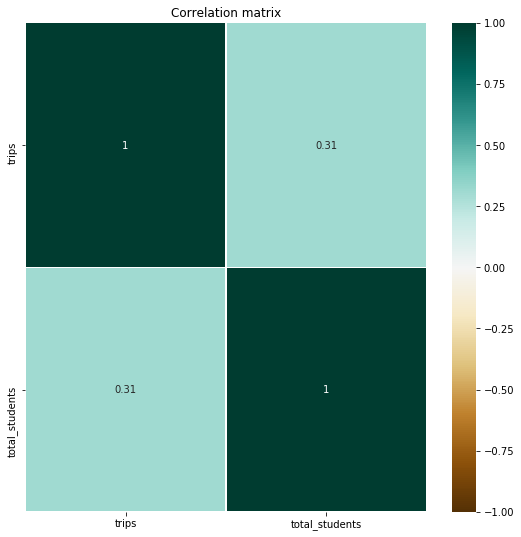

In [73]:
heatmap_corr(poi_od.corr())

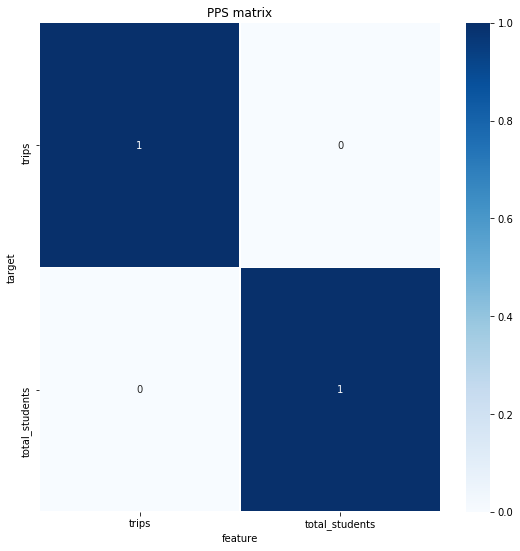

In [72]:
heatmap_pps(pps.matrix(poi_od))

### Comparing bike trips with high schools and universities

In [40]:
grids_and_high_education = gpd.sjoin(boston_high_education,pl.placement1_10,op='within')
grids_and_high_education.drop(columns='index_right', inplace=True)
grid_high_education_occurrences = grids_and_high_education.groupby(['id','placement_id'], as_index=False).agg({'i':'count'})
grid_high_education_occurrences.rename(columns={'i':'occurrences'},inplace=True)
grid_high_education_occurrences.head()

/home/higor/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != +init=epsg:4326 +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


id  placement_id  occurrences
0  250002600530             0            1
1  250004600819             0            1
2  250004901245             0            1
3  250005301256             0            1
4  250005401258             0            1

#### Merging grid cells and education POIs

In [41]:
grid_cells_and_high_education = grids_and_high_education.merge(grid_high_education_occurrences, on=['id','placement_id'])
grid_cells_and_high_education.head()

id                                               name  \
0        164641                                  BAY STATE COLLEGE   
1        167093                   NEW ENGLAND COLLEGE OF OPTOMETRY   
2        487144  AMERICAN ACADEMY OF PERSONAL TRAINING-BOSTON C...   
3        164872                       BOSTON ARCHITECTURAL COLLEGE   
4  250279000217             SNOWDEN INTERNATIONAL SCHOOL AT COPLEY   

   total_students                    geometry  i  j  placement_id  occurrences  
0             717  POINT (-71.07694 42.35180)  4  5             0            1  
1             527  POINT (-71.08688 42.35189)  4  5             0            1  
2              40  POINT (-71.07628 42.35069)  4  5             0            1  
3             695  POINT (-71.08561 42.34849)  4  5             0            1  
4             489  POINT (-71.07792 42.35059)  4  5             0            1

#### Counting enrolled students per grid cell

In [42]:
students_per_cells_high = grid_cells_and_high_education.groupby(cell_id,as_index=False).agg({'total_students':'sum'})
students_per_cells_high.head()

i  j  placement_id  total_students
0  0  3             0             816
1  0  5             0             403
2  0  6             0            1030
3  1  0             0             457
4  1  2             0             578

#### Visualizing education POIs and bike stations

In [159]:
fmap = grid.map_around(plot_grid=True)
for index, row in boston_high_education.iterrows():
    folium.CircleMarker(location=[row.geometry.y,row.geometry.x], radius=3,
                        popup=row['name'] + ' ' +str(row.total_students), color='blue').add_to(fmap)
flow.draw_stations(fmap, stations)
            #break
#file = 'maps/poi_group_colored.html'
#fmap.save(file)
fmap

#### Getting POIs per origin cells

In [74]:
poi_od_orig_high = students_per_cells_high.merge(od, left_on=['i', 'j'],right_on=['i_start','j_start'])
poi_od_orig_high.drop(columns=['i_start','j_start','i_end','j_end'],inplace=True)
poi_od_orig_high = poi_od_orig_high.rename(columns={'trip counts': 'trips'})
poi_od_orig_high.head()

i  j  placement_id  total_students  trips
0  0  3             0             816      8
1  0  3             0             816      2
2  0  3             0             816     68
3  0  3             0             816      2
4  0  3             0             816      1

#### Getting POIs per destination cells

In [75]:
poi_od_dest_high = students_per_cells_high.merge(od, left_on=['i', 'j'],right_on=['i_end','j_end'])
poi_od_dest_high.drop(columns=['i_start','j_start','i_end','j_end'],inplace=True)
poi_od_dest_high = poi_od_dest_high.rename(columns={'trip counts': 'trips'})
poi_od_dest_high.head()

i  j  placement_id  total_students  trips
0  0  3             0             816      8
1  0  3             0             816    207
2  0  3             0             816      2
3  0  3             0             816      1
4  0  3             0             816      1

#### Choosing origin or destination cells to correlate with POIs

In [78]:
poi_od_high = poi_od_orig_high.copy()
poi_od_high = poi_od_high.groupby(['i','j'], as_index=False).agg({'trips':'sum','total_students':'first'})
poi_od_high.drop(columns=['i','j'],inplace=True)
poi_od_high.head(10)

trips  total_students
0    132             816
1    380             403
2    118            1030
3   5258             107
4    849              95
5    692            1767
6   1434              53
7   2239           18277
8   3155            1627
9   8363            2576

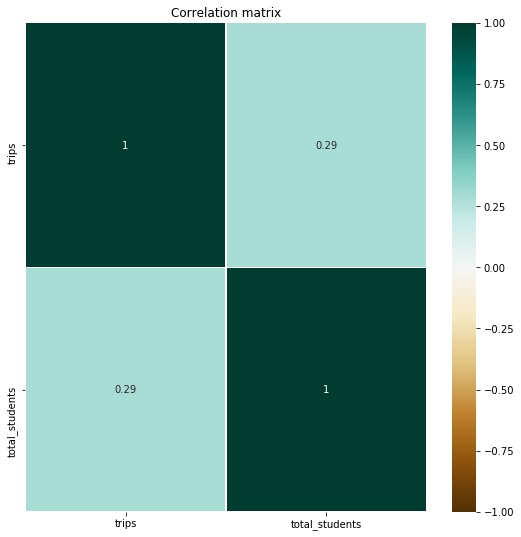

In [79]:
heatmap_corr(poi_od_high.corr())

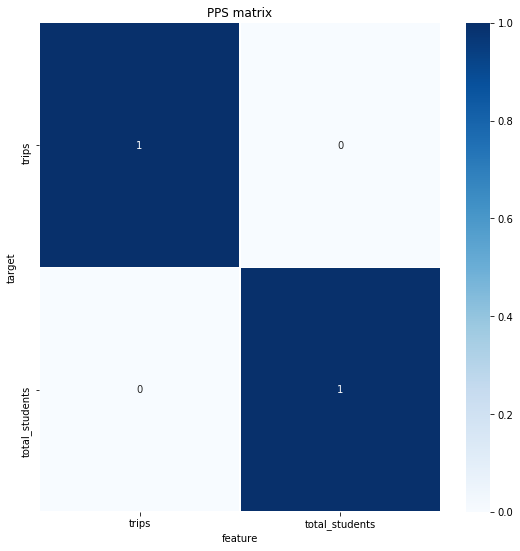

In [63]:
heatmap_pps(pps.matrix(poi_od_high))